## Imports


In [142]:
import os
import matplotlib.pyplot as plt

import requests
import tarfile
import os

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [128]:
RUNS_ON_COLLAB = False

if RUNS_ON_COLLAB:
    # URL of the dataset
    url = 'https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz'

    # Create the images directory if it does not exist
    os.makedirs('images2', exist_ok=True)

    # Download the dataset
    response = requests.get(url, stream=True)

    # Check if the download was successful
    if response.status_code == 200:
        # Open a local file for writing the downloaded content
        with open('images2/images.tar.gz', 'wb') as f:
            f.write(response.raw.read())
        
        # Extract the tar file
        with tarfile.open('images2/images.tar.gz', 'r:gz') as tar:
            tar.extractall(path='images2')
        
        print("Download and extraction complete!")
    else:
        print("Failed to download the file. Status code:", response.status_code)


## Definition of global constants

In [129]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'images')

## Creation of Dataset and Dataset helper functions

We store the labels for each image by creating a dict {'image-name' : [label1, label2, label3]} using list.txt

In [130]:
def create_image_labels(file : str):
    """
    This function takes a file name as argument and returns a dict containing the image-name, label pairs and a list of the image names in the order they 
    appear in the list.
    Args:
        file : str, denotes the filename for the file containing the images and labels ()
    Returns:
        IMG_LABELS : dict, format {'image-name' : [label1, label2, label3]}
        IMG_NAMES : list, ['image1-name', image2, ...]
    """
    import re
    IMG_LABELS = {}
    IMG_NAMES = []
    pattern = r'^[A-Za-z0-9_]+\s+\d+\s+\d+\s+\d+$'
    # Function to check if a line is valid
    def is_valid_line(line):
        return re.match(pattern, line) is not None

    filename = 'annotations/' + file
    # create dict from list.txt
    with open(filename, 'r') as file:

        # Read each line in the file
        for line in file:
            # use regex
            if is_valid_line(line):
                # Split the line into tokens
                tokens = line.split()
                
                # Extract the image name and attributes
                image_name = tokens[0]
                attributes = [int(token) for token in tokens[1:]]
                IMG_NAMES.append(image_name)
                # Add entry to the dictionary
                IMG_LABELS[image_name] = attributes
    
    print(IMG_LABELS, IMG_NAMES)
    return IMG_LABELS, IMG_NAMES

Lets define the dataset. We let the "target_transform" function specify if we want the binary label or breed etc

In [131]:
from torchvision.io import ImageReadMode

class CatAndDogsDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        """
        self.img_labels = {'Abyssninan101' : [1, 1, 1], ...}
        self.img_names = ['Abyssnian101', ...]
        """
        self.img_labels, self.img_names = create_image_labels(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+'.jpg')
        image = read_image(img_path, mode=ImageReadMode.RGB) # this is intended to solve problem with extra channel on one image
        label = self.img_labels[img_name]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Defining transforms for images and labels. These are used for preprocessing each image used in the model

In [132]:
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights

# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
train_transform = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = v2.Compose([
    v2.Resize(size=(224, 224), antialias=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])



binary_transform = lambda x: x[1]-1 # for binary classification problem we only care about the cat/dog label
# 37 classes
def breed_transform(x):
    return x[0]-1


## Finetuning a pretrained model for binary-classification problem

First we download the model with pretrained weights and change the fully connected layer

In [133]:
from torchvision import models
from torch import nn


model = models.resnet34(weights='DEFAULT')
layers = list(model.children())

print(layers)

num_classes = 37

# Freeze all layers except last one
for param in model.parameters():
    param.requires_grad = False

# Change the output layer
in_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

We now define the training/test functions as implemented in 
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [134]:
def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, **kwargs):
    """
    Args:
        **kwargs : {
            'print_every' : int,
        }
    """
    print_every = int(kwargs.get('print_every', 10))

    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    model.to(device)  # Move the model to the device
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)  # Move the data to the device

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if DEBUG and batch % print_every == 0:
            loss, current_batch = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  Current image:[{current_batch:>5d}/{size:>5d}]")

In [135]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Next we create the datasets for training, validation and testing

In [136]:
training_data = CatAndDogsDataset('trainval.txt', IMAGE_PATH, transform=train_transform, target_transform=breed_transform)
validation_data = CatAndDogsDataset('trainval.txt', IMAGE_PATH, transform=val_transform, target_transform=breed_transform)
test_data = CatAndDogsDataset('test.txt', IMAGE_PATH, transform=val_transform, target_transform=breed_transform)

"""
What follows is a hacky way to shuffle the train/val-data into a training and validation set
"""
# shuffle and split into validation and training
import random

indices = list(range(len(training_data)))
random.seed(310)  # fix the seed
random.shuffle(indices)

train_size = int(0.8 * len(training_data))
train_dataset_split = torch.utils.data.Subset(training_data, indices[:train_size])
val_dataset_split = torch.utils.data.Subset(validation_data, indices[train_size:])

{'Abyssinian_100': [1, 1, 1], 'Abyssinian_101': [1, 1, 1], 'Abyssinian_102': [1, 1, 1], 'Abyssinian_103': [1, 1, 1], 'Abyssinian_104': [1, 1, 1], 'Abyssinian_105': [1, 1, 1], 'Abyssinian_106': [1, 1, 1], 'Abyssinian_107': [1, 1, 1], 'Abyssinian_108': [1, 1, 1], 'Abyssinian_109': [1, 1, 1], 'Abyssinian_10': [1, 1, 1], 'Abyssinian_110': [1, 1, 1], 'Abyssinian_111': [1, 1, 1], 'Abyssinian_112': [1, 1, 1], 'Abyssinian_113': [1, 1, 1], 'Abyssinian_114': [1, 1, 1], 'Abyssinian_115': [1, 1, 1], 'Abyssinian_116': [1, 1, 1], 'Abyssinian_117': [1, 1, 1], 'Abyssinian_118': [1, 1, 1], 'Abyssinian_119': [1, 1, 1], 'Abyssinian_11': [1, 1, 1], 'Abyssinian_120': [1, 1, 1], 'Abyssinian_121': [1, 1, 1], 'Abyssinian_122': [1, 1, 1], 'Abyssinian_123': [1, 1, 1], 'Abyssinian_124': [1, 1, 1], 'Abyssinian_125': [1, 1, 1], 'Abyssinian_126': [1, 1, 1], 'Abyssinian_127': [1, 1, 1], 'Abyssinian_128': [1, 1, 1], 'Abyssinian_129': [1, 1, 1], 'Abyssinian_12': [1, 1, 1], 'Abyssinian_130': [1, 1, 1], 'Abyssinian_131'

Now we set the hyperparameters for training

In [137]:
learning_rate = 1e-3
batch_size = 32
epochs = 5

We create the loaders for the datasets to speedup processing

In [138]:
train_dataloader = DataLoader(train_dataset_split, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_split, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

We train the network using said parameters, running the test-loop on the validation set for each epoch to see if the model improves

In [143]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

summary(model, (3, 224, 224))

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(val_dataloader, model, loss_fn, device)
print("Training done!")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Corrupt JPEG data: premature end of data segment


loss: 1.662769  Current image:[ 1952/ 2944]
loss: 1.544452  Current image:[ 2272/ 2944]
loss: 1.406218  Current image:[ 2592/ 2944]
loss: 1.359666  Current image:[ 2912/ 2944]


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 83.0%, Avg loss: 0.975815 

Epoch 2
-------------------------------
loss: 1.234583  Current image:[   32/ 2944]


Corrupt JPEG data: premature end of data segment


loss: 1.133556  Current image:[  352/ 2944]
loss: 1.122439  Current image:[  672/ 2944]
loss: 1.146646  Current image:[  992/ 2944]
loss: 1.073327  Current image:[ 1312/ 2944]
loss: 1.240544  Current image:[ 1632/ 2944]
loss: 0.999544  Current image:[ 1952/ 2944]
loss: 0.742269  Current image:[ 2272/ 2944]
loss: 0.829001  Current image:[ 2592/ 2944]
loss: 1.220783  Current image:[ 2912/ 2944]


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 85.9%, Avg loss: 0.606031 

Epoch 3
-------------------------------
loss: 0.647503  Current image:[   32/ 2944]


Corrupt JPEG data: premature end of data segment


loss: 1.006989  Current image:[  352/ 2944]
loss: 0.702536  Current image:[  672/ 2944]
loss: 0.850831  Current image:[  992/ 2944]
loss: 0.912935  Current image:[ 1312/ 2944]
loss: 0.689026  Current image:[ 1632/ 2944]
loss: 0.784584  Current image:[ 1952/ 2944]
loss: 0.855653  Current image:[ 2272/ 2944]
loss: 0.703590  Current image:[ 2592/ 2944]
loss: 0.746051  Current image:[ 2912/ 2944]


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 87.5%, Avg loss: 0.481467 

Epoch 4
-------------------------------
loss: 0.927550  Current image:[   32/ 2944]
loss: 0.882085  Current image:[  352/ 2944]
loss: 0.889372  Current image:[  672/ 2944]
loss: 0.848445  Current image:[  992/ 2944]
loss: 0.347544  Current image:[ 1312/ 2944]
loss: 0.670880  Current image:[ 1632/ 2944]
loss: 0.512867  Current image:[ 1952/ 2944]
loss: 0.313882  Current image:[ 2272/ 2944]
loss: 0.886743  Current image:[ 2592/ 2944]


Corrupt JPEG data: premature end of data segment


loss: 0.810658  Current image:[ 2912/ 2944]


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 88.6%, Avg loss: 0.397827 

Epoch 5
-------------------------------
loss: 0.778152  Current image:[   32/ 2944]
loss: 0.712721  Current image:[  352/ 2944]
loss: 0.795434  Current image:[  672/ 2944]


Corrupt JPEG data: premature end of data segment


loss: 0.801806  Current image:[  992/ 2944]
loss: 0.893283  Current image:[ 1312/ 2944]
loss: 0.811958  Current image:[ 1632/ 2944]
loss: 0.381937  Current image:[ 1952/ 2944]
loss: 0.429815  Current image:[ 2272/ 2944]
loss: 0.651487  Current image:[ 2592/ 2944]
loss: 0.315313  Current image:[ 2912/ 2944]


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Test Error: 
 Accuracy: 88.7%, Avg loss: 0.381375 

Training done!


Finally we check the final result on the test-dataset

In [163]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.034052 



Lets see some examples

In [166]:
# show 10 images and the label that the model predicts
def visualize_model(model, num_images=10):
    label_to_pred = {'0': 'Cat', '1': 'Dog'}
    model.eval()
    
    fig, axs = plt.subplots(1, num_images, figsize=(20, 20))

    with torch.no_grad():
        for i in range(num_images):
            # randomize image to plot
            idx = random.randint(0, len(test_data))
            img, label = test_data[idx]
            pred = model(img.unsqueeze(0))
            pred_label = pred.argmax(1).item()
            axs[i].imshow(img.permute(1, 2, 0))
            axs[i].set_title(f"Predicted: {label_to_pred[str(pred_label)]} \n True: {label_to_pred[str(label)]}")
            axs[i].axis('off')
    plt.show()
    
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

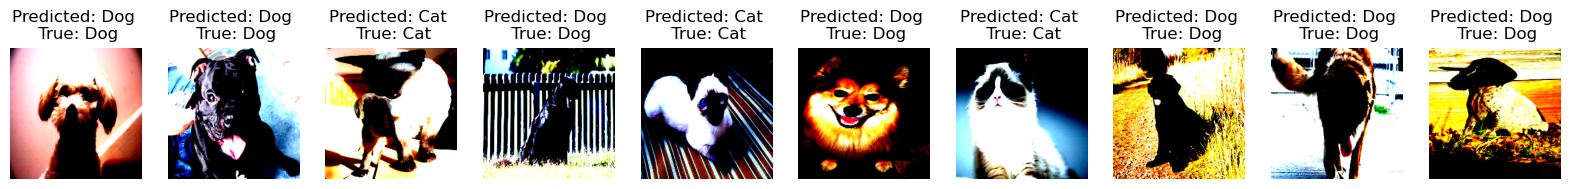

In [169]:
visualize_model(model)